In [2]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')

/home/vimalkumar.s/Documents/python_new/cde_venv/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [52]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        print(type(mask))
        #plt.imshow(mask)
        ff = Image.fromarray(mask)
        ff.save('/home/vimalkumar.s/Documents/table splitting/2/test/masking.jpeg')
        img = cv2.imread('/home/vimalkumar.s/Documents/table splitting/2/test/masking.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,100,200)
        lines = cv2.HoughLinesP(edges,1,np.pi/180,50,maxLineGap = 20000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),25)
            cv2.imwrite('/home/vimalkumar.s/Documents/table splitting/2/test/final_image.jpeg',img)
        #plt.imshow(mask)    
        cnt = cv2.imread('/home/vimalkumar.s/Documents/table splitting/2/test/final_image.jpeg',0)   
        contours, heirarchy = cv2.findContours(
            cnt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/table splitting/2/page_4/cells')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.jpeg".format(i, j)
                path = os.path.join(out_path, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths
    f = '/home/vimalkumar.s/Documents/table splitting/2/page_4/file/pg_4.jpeg'
    main(f)

<class 'numpy.ndarray'>


['/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/000-000.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/000-001.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/000-002.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/001-000.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/001-001.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/001-002.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/002-000.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/002-001.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/002-002.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/003-000.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/003-001.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/003-002.jpeg',
 '/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/004-000.jpeg',

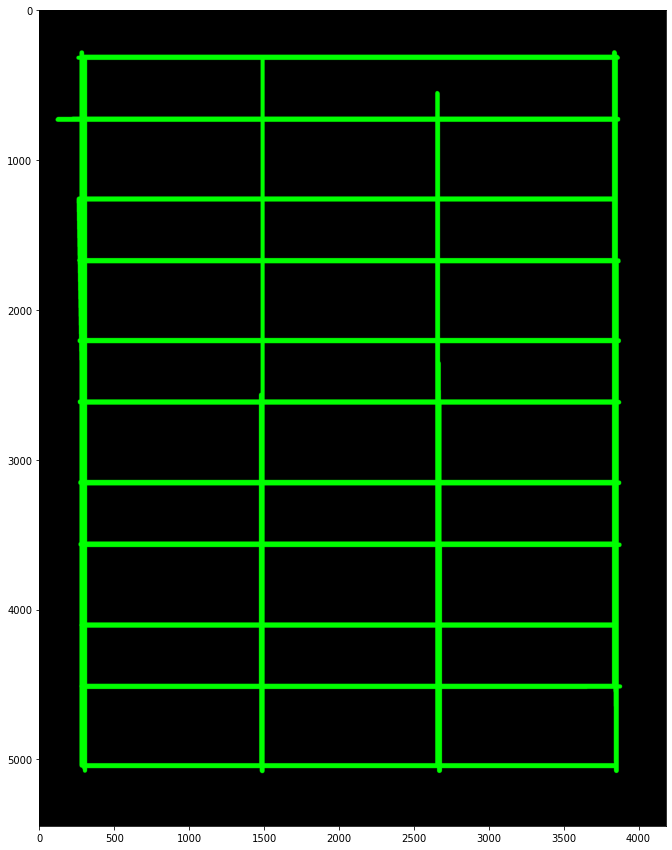

In [42]:
import numpy
import cv2

img = cv2.imread('pg_1_table.jpeg')
#im = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200)
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,maxLineGap = 20000)

for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),25)
    #print(type(img))
    #cv2.imwrite('final_image.jpeg',img)
plt.figure(figsize=(15,15))
plt.imshow(img)
#print(type(img))

In [26]:
xx = cv2.imread('final_image.jpeg',0)
contours, heirarchy = cv2.findContours(
            xx, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

In [18]:
iml = cv2.imread('/home/vimalkumar.s/Documents/table splitting/test/masking.jpeg')


In [19]:
print(type(iml))

<class 'numpy.ndarray'>


['/home/vimalkumar.s/Documents/table splitting/1/sample/test/000-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/001-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/001-001.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/002-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/003-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/004-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/004-001.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/004-002.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/005-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/005-001.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/005-002.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/006-000.png',
 '/home/vimalkumar.s/Documents/table splitting/1/sample/test/006-001.png',
 '/home/vimalkumar.s/Docu

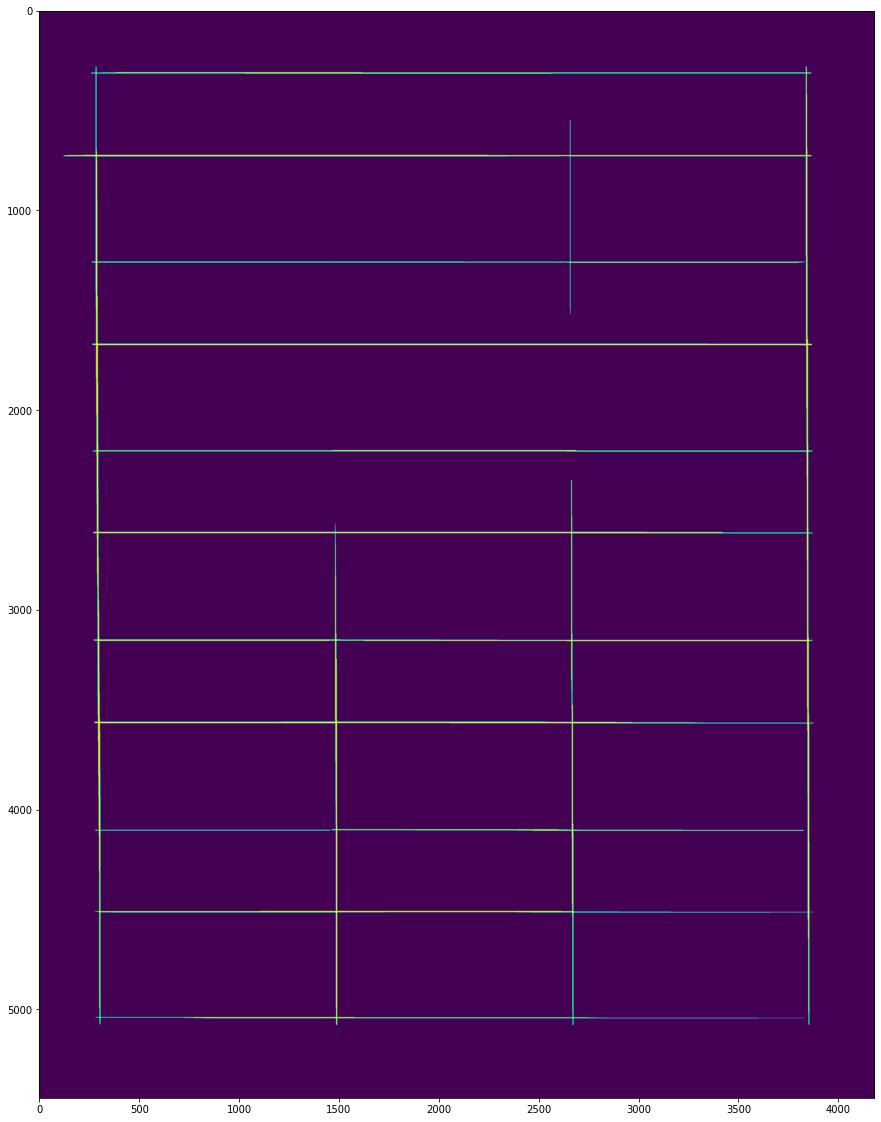

In [19]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        plt.figure(figsize=(20,20))
        plt.imshow(mask)
        jj = Image.fromarray(mask)
        jj.save('pg_1_table.jpeg')
        contours, heirarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/table splitting/1/sample/test')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.png".format(i, j)
                path = os.path.join(out_path, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths
    f = '/home/vimalkumar.s/Documents/table splitting/2/page_1/file/pg_1.jpeg'
    main(f)

In [32]:
import pytesseract
x = pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/2/page_4/cells/001-000.jpeg')

In [33]:
print(x)

56,150 anes p51 CA 00345

2429 S XANADU ARAP  s57,875

TypTWNée -C STRAWBERRY Br2 Ba2 $q1100

Ln38,945 Bast C tvl Mb15X13 u:1 F 351

TypCV 0.00 & Fint Fpi L FrOXO M:1 F 749

PIT $465F GarC.D 2 HrG,FA Lr24X13 L:

Tx 620 Fe127M Inc1CL,EM.IN, prOXO = _—8B::

MIPN eae FlinN PL,SN TR ‘WS Kt 10X9 one sty2S

Trm CV,F,C 2.80 2.80 ER

Rmk LIKE NEW, GOLF COURSE, PATIO, UPGRADES, wow
AC,CI,DE,DW,ES,LM,LO,MS,PC,RF,SA,SW,UP,VL,W!

Let DEBBIE OWENS Pn688-8824 s5080 -5740 -59

of fREMAX PARKER PnB41-0922 §=2 80014661995



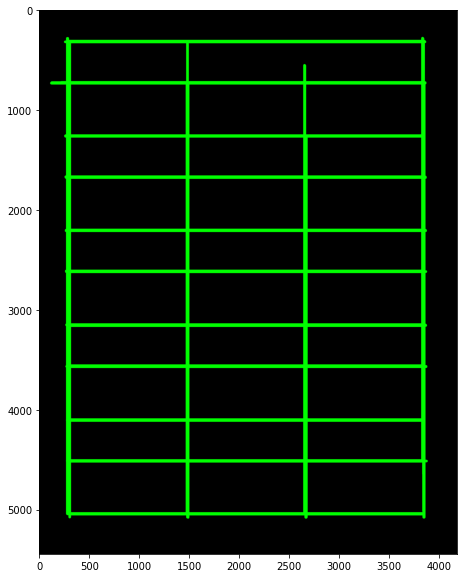

In [6]:
        img = cv2.imread('/home/vimalkumar.s/Documents/table splitting/3/file/test/masking.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,100,200)
        lines = cv2.HoughLinesP(edges,2,np.pi/180,500,minLineLength = 0.1,maxLineGap = 5000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),25)
        plt.figure(figsize=(10,10))
        plt.imshow(img)

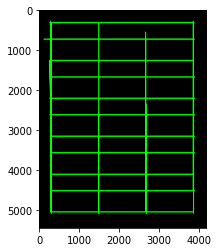

In [46]:
        img = cv2.imread('pg_1_table.jpeg')
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,100,200)
        lines = cv2.HoughLinesP(edges,1,np.pi/180,50,maxLineGap = 20000)

        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),25)
        plt.imshow(img)

In [10]:
#im = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
#print(type(im))
#imm = Image.fromarray(im)
imm = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
imm.save('/home/vimalkumar.s/Documents/table splitting/quality/pre_processed_image.jpeg',quality = 100)

In [29]:
# External libraries used for
# Image IO
from PIL import Image

# Morphological filtering
from skimage.morphology import opening
from skimage.morphology import disk

# Data handling
import numpy as np

# Connected component filtering
import cv2

black = 0
white = 255
threshold = 160

img = Image.open("/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg").convert("LA")
pixels = np.array(img)[:,:,0]

# Remove pixels above threshold
pixels[pixels > threshold] = white
pixels[pixels < threshold] = black

# Morphological opening
blobSize = 1 # Select the maximum radius of the blobs you would like to remove
structureElement = disk(blobSize)  # you can define different shapes, here we take a disk shape
# We need to invert the image such that black is background and white foreground to perform the opening
pixels = np.invert(opening(np.invert(pixels), structureElement))

# Create and save new image.
newImg = Image.fromarray(pixels).convert('RGB')
newImg.save("/home/vimalkumar.s/Documents/table splitting/quality/newImage1.PNG")

# Find the connected components (black objects in your image)
# Because the function searches for white connected components on a black background, we need to invert the image
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.invert(pixels), connectivity=8)

# For every connected component in your image, you can obtain the number of pixels from the stats variable in the last
# column. We remove the first entry from sizes, because this is the entry of the background connected component
sizes = stats[1:,-1]
nb_components -= 1

# Define the minimum size (number of pixels) a component should consist of
minimum_size = 100

# Create a new image
newPixels = np.ones(pixels.shape)*255

# Iterate over all components in the image, only keep the components larger than minimum size
for i in range(1, nb_components):
    if sizes[i] > minimum_size:
        newPixels[output == i+1] = 0

# Create and save new image.
newImg = Image.fromarray(newPixels).convert('RGB')
newImg.save("/home/vimalkumar.s/Documents/table splitting/quality/newImage2.PNG")

In [32]:
from PIL import Image

black = (0,0,0)
white = (255,255,255)
threshold = (165,165,165)

# Open input image in grayscale mode and get its pixels.
img = Image.open("/home/vimalkumar.s/Documents/table splitting/quality/001-002.jpeg").convert("LA")
pixels = img.getdata()

newPixels = []

# Compare each pixel 
for pixel in pixels:
    if pixel < threshold:
        newPixels.append(black)
    else:
        newPixels.append(white)

# Create and save new image.
newImg = Image.new("RGB",img.size)
newImg.putdata(newPixels)
newImg.save("/home/vimalkumar.s/Documents/table splitting/quality/new_image2.jpeg")


In [19]:
img_1 = pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
print(img_1)

61,450 31-Aug-92 p35 CV 00345

650 S DALE CT DENV 559,950
TyRES znR1) = SubMOUNTAINVIEW Br2 Ba2 5Sq1130
Ln42,486 Lor 7200 w Mb14X12 U:

TyV 0.00 % Bst C Acr FrOXO m:2 FT 1130
PIT| $633 F Pint Pp Lr16X10 Lt:

T< 590 FlInN GarG,A 1 HtG,FA pr12X10 B:

MIP N ¥r1946 swrPUB wWerPUB kt7X10 cstBR Sty A

trm CV,F,V,SO S 2.80 B 2.80 ER

Rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,DR,DS,ES,FD,FE,LI.NP,RF,ST.SW,WC,.WW

LstDEVOL/MUNEKATA ph696-7364 56220 -8780 -

or fF RE/MAX 3000 Ph696-7676 2580219 | 668528



In [73]:
img_2 = pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/newImage.jpg')
print(img_2)

61,450 31-Aug-92 vD 35 CV 00345

650 S DALE CT DENV :59,950
TyRES znRt = SubMOUNTAINVIEW Br2 Ba2 Sqi130
Ln42,486 Lot 7200 Ww Mb14X12 u:

TyV 0.00 & Bat C aAcr FrOXO s:2 FT 1130

PITl $633 F Fint Pp Lr16X10 Lv:

Tx §90 FlinN GarG,A 1 HtG,FA pdr12X10 Bs:

mip N yr1946 swrPUB werPUs Ke 7X10 cCsatBR sty R

Trm CV,F,V.SQ 2.80 hn 2.80 ER

Rink PERFECT CONDITION"NEWER CARPETINEW PAINT!
CP,DR,OS,ES,FD,FE,LINP,RF,.ST.SW.WC.WW

Lst DEVOL/MUNEKATA Pn696-7364 s6220 -6780 -69

o¢ RE/MAX 3000 pné696-7676 2p80219 | 668528



In [49]:
im = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
print(im.info)

{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


In [50]:
im = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/dpi_image.jpeg')

In [51]:
print(im.info)

{'jfif': 257, 'jfif_version': (1, 1), 'dpi': (400, 400), 'jfif_unit': 1, 'jfif_density': (400, 400)}


In [46]:
im.save('/home/vimalkumar.s/Documents/table splitting/quality/dpi_image.jpeg',dpi = (400,400))

In [24]:
import scipy 
scipy.version.full_version

'1.6.3'

In [25]:
pip install scipy==1.1.0

  Using cached scipy-1.1.0.tar.gz (15.6 MB)
  ERROR: Command errored out with exit status 1:
   command: /home/vimalkumar.s/Documents/python_new/cde_venv/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-cc_aclh5
       cwd: /tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/
  Complete output (127 lines):
  /tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py:114: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation fo

  ERROR: Command errored out with exit status 1:
   command: /home/vimalkumar.s/Documents/python_new/cde_venv/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' clean --all
       cwd: /tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2
  Complete output (11 lines):
  /tmp/pip-install-ahcwxmle/scipy_bbdabaa7df4d462f956cbbe4307751e2/setup.py:114: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp
  
  `setup.py clean` is not supported,

Note: you may need to restart the kernel to use updated packages.


In [23]:
import scipy.misc
from scipy import misc
from scipy.misc.pilutil import Image
 
im = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
im_array = scipy.misc.fromimage(im)
im_inverse = 255 - im_array
im_result = scipy.misc.toimage(im_inverse)
misc.imsave('/home/vimalkumar.s/Documents/table splitting/quality/result.tiff',im_result)

ModuleNotFoundError: No module named 'scipy.misc.pilutil'

In [62]:
image_file = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
#a = Image.fromarray(image_file)
image_file.save('/home/vimalkumar.s/Documents/table splitting/quality/sample.jpeg',quality=150)

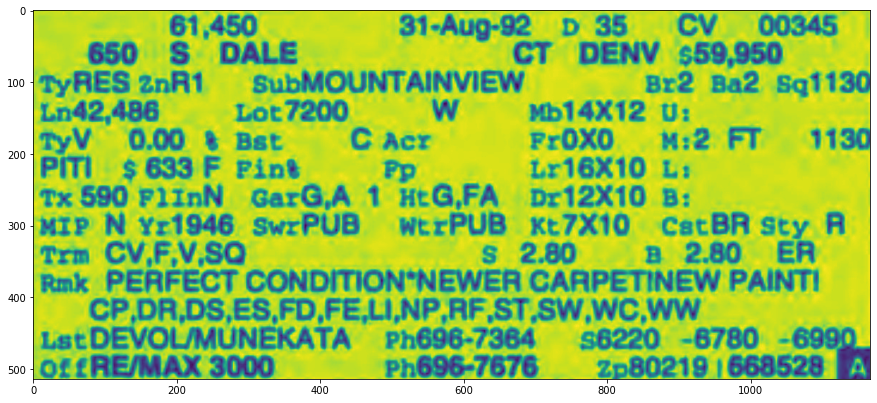

In [58]:
plt.figure(figsize=(15,15))
plt.imshow(image_file)

In [17]:
import pytesseract
print(pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg'))

61,450 31-Aug-92 p35 CV 00345

650 S DALE CT DENV 559,950
TyRES znR1) = SubMOUNTAINVIEW Br2 Ba2 5Sq1130
Ln42,486 Lor 7200 w Mb14X12 U:

TyV 0.00 % Bst C Acr FrOXO m:2 FT 1130
PIT| $633 F Pint Pp Lr16X10 Lt:

T< 590 FlInN GarG,A 1 HtG,FA pr12X10 B:

MIP N ¥r1946 swrPUB wWerPUB kt7X10 cstBR Sty A

trm CV,F,V,SO S 2.80 B 2.80 ER

Rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,DR,DS,ES,FD,FE,LI.NP,RF,ST.SW,WC,.WW

LstDEVOL/MUNEKATA ph696-7364 56220 -8780 -

or fF RE/MAX 3000 Ph696-7676 2580219 | 668528



In [16]:
import pytesseract
print(pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/ss1.jpeg'))

61,450 31-Aug-92 D 35 CV 00345

650 S DALE CT DENV 559,950
TyRES znR1) =SubMOUNTAINVIEW Br2 Ba2 5q1130
Ln42,486 Lor7200 Ww Mb14X12 wu:

TyV 0.00 & Bst C aAcr FrOXO m:2 FT 1130
PIT| $633 F Fint Pp Lr16X10 Lt:

Tx 590 FlInN GarG,A 1 HtG,FA pr12X10 B:

MIP N yr1946 swrPUB wWerPUB xKt7X10 catBR sty A

tTrm CV,F,V,SQ S 2.80 B 2.80 ER

rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,DR,DS,ES,FD,FE,LI,NP,RF,ST.SW,WC,WW

LstDEVOL/MUNEKATA ph696-7364 56220 -6780 -

of fRE/MAX 3000 Ph696-7676 2580219 | 668528



In [78]:
import cv2
import numpy as np
import easyocr
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

reader = easyocr.Reader(['en'],gpu = False)
image = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
r_easy_ocr=reader.readtext(thresh,detail=0)
print(r_easy_ocr)

Using CPU. Note: This module is much faster with a GPU.


['61,450', '31-Aug 92', 'D 35', 'Cv', '00345', '650', 'DALE', 'CT', 'DENV 559,950', 'TyRES znr1', 'SubMOUNTAINVIEW', 'Brz', '942 Sq1130', 'Ln42,486', 'Lo.7200', 'W', 'Mb14X12', 'U:', '0,00', 'Bst', 'Rur', "'roxo", '4,2', 'FT', '1130', 'Piti', '$ 633 F Finb', 'Irigx10 L}', 'Tx 590 PlInN', 'GarG,A', '1', 'MtG,FA', 'Dr12X10', '8;', 'HIP N Yr1946 SwrPUB', 'WtrPUB', 'Kezxiq', 'CatBa sty R', 'Trm CV FV S0', '5', '2.80', '0', '2.80', 'ea', 'Rak PEAFECT CONDITION NEWEA CAAPETINEW PAINTI', 'CP Da,ds ES FD,FE,LI,NP af ST,SW WC,WW', 'LSLDEVOUMUNEKATA', 'Ph696-7384', '56220', '~8780', '699', 'OIEREMMMAX 300', 'Ph696-7676', '2080219', '658528', 'TyV']


In [1]:
import cv2
import numpy as np
import easyocr
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

reader = easyocr.Reader(['en'],gpu = False)
image = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/we.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
r_easy_ocr=reader.readtext(thresh,detail=0)
print(r_easy_ocr)

Using CPU. Note: This module is much faster with a GPU.


KeyboardInterrupt: 

In [14]:
import cv2
import numpy as np
 
im = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
im = im/255.0
im_power_law_transformation = cv2.pow(im,0.6)
a = Image.fromarray((im_power_law_transformation * 255).astype(np.uint8))
a.save('/home/vimalkumar.s/Documents/table splitting/quality/ss1.jpeg',quality = 99)

In [10]:
print(type(im_power_law_transformation))

<class 'numpy.ndarray'>


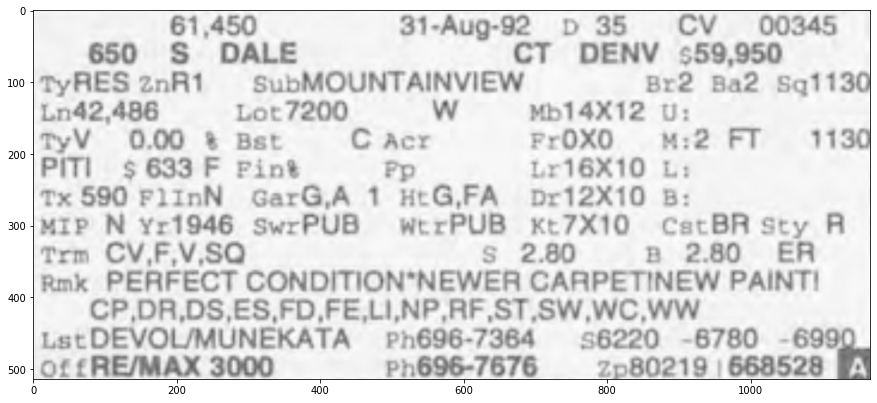

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(im_power_law_transformation)

In [11]:
from PIL import Image
import numpy as np

In [20]:
x = Image.fromarray((im_power_law_transformation * 255).astype(np.uint8))

In [5]:
from PIL import Image

im = Image.open("/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg")
im.save("/home/vimalkumar.s/Documents/table splitting/quality/test-600.jpeg", dpi=(1000,1000))

In [7]:
import pytesseract
print(pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/test-600.png'))

61,450 31-Aug-92 p35 CV 345
650 S$ CT DENV 559,950
TyRES znR1) = SubMOUNTAINVIEW Br2 Ba2 5Sq1130
Ln42,486 Lor7200 Ww U:

Mb14X12
TyV 0.00 % Bst C Acr FrOXO m:2 FT 1130
PIT| $633 F Pint Pp Fah he Ls
TT 590 FlInN GarG,A 1 HtG,FA pdr
MIP N yr1946 swrPUB WerPUB ReyxIO. catBR Sty A
tTrm CV,F,V,
Rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!

CP,DR,DS,ES,FD FEL NP, RF = ph 9
DEVOL/MUNEKATA | Pn696-7364 sos ON
or fF RE/MAX 3000 cnaee- 7876 See poten



In [9]:
from PIL import Image
# set the base width of the result
basewidth = 300
img = Image.open('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
# determining the height ratio
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
# resize image and save
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/home/vimalkumar.s/Documents/table splitting/quality/sompic.jpg') 

In [11]:
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract

img = Image.open(r'/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')
new_size = tuple(4*x for x in img.size)
img = img.resize(new_size, Image.ANTIALIAS)
img.save(r'/home/vimalkumar.s/Documents/table splitting/quality/test02.jpeg', 'JPEG')

In [12]:
print(pytesseract.image_to_string('/home/vimalkumar.s/Documents/table splitting/quality/test02.jpeg'))

61,450 31-Aug-92 p35 CV 00345

650 S DALE CT DENV 559,950
TyRES znR1 2 3=6sSsubMOUNTAINVIEW Br2 Ba2 Sqi130
Ln42,486 Lor 7200 WN Mb14X12 wu:

TyV 0.00 & Bst C Acr FrOXO m:2 FT 1130

PIT| $633 F Pint Pp Lri16X10 L:
Tx 590 FlInN GarG,A 1 HtG,FA pri2X10 B:
MIP N yr1946 SwrPUB wWerPUB kKt7X10 catBR Sty A
tTrm CV.F.V.,SO S 2.80 B 2.80 ER
rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,.DR,.DS,ES,FD,FE,LI.NP.RF.ST.SW.WC.WW
LetDEVOL/MUNEKATA pen696-7364 56220 -8780 -
of fRE/MAX 3000 P)696-7676 72p80218 | 668528

 
    



In [16]:
import numpy as np 
import cv2
# load image
image = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')

# create grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# perform threshold
retr, mask = cv2.threshold(gray_image, 190, 255, cv2.THRESH_BINARY)

# findcontours
contours, hier = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# select the largest contour
largest_area = 0
for cnt in contours:
    if cv2.contourArea(cnt) > largest_area:
        cont = cnt
        largest_area = cv2.contourArea(cnt)

# find the rectangle (and the cornerpoints of that rectangle) that surrounds the contours / photo
rect = cv2.minAreaRect(cont)
box = cv2.boxPoints(rect)
box = np.int0(box)

#### Warp image to square
# assign cornerpoints of the region of interest
pts1 = np.float32([box[2],box[3],box[1],box[0]])
# provide new coordinates of cornerpoints
pts2 = np.float32([[0,0],[500,0],[0,110],[500,110]])

# determine and apply transformationmatrix
M = cv2.getPerspectiveTransform(pts1,pts2)
tmp = cv2.warpPerspective(image,M,(500,110))

 # create grayscale
gray_image2 = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
# perform threshold
retr, mask2 = cv2.threshold(gray_image2, 160, 255, cv2.THRESH_BINARY_INV)

# remove noise / close gaps
kernel =  np.ones((5,5),np.uint8)
result = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)

#draw rectangle on original image
cv2.drawContours(image, [box], 0, (255,0,0), 2)

# dilate result to make characters more solid
kernel2 =  np.ones((3,3),np.uint8)
result = cv2.dilate(result,kernel2,iterations = 1)

#invert to get black text on white background
result = cv2.bitwise_not(result)

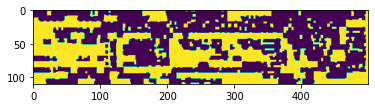

In [20]:
import matplotlib.pyplot as plt
plt.imshow(result)

In [17]:
type(result)

numpy.ndarray

In [18]:
x = Image.fromarray(result)
x.save('/home/vimalkumar.s/Documents/table splitting/quality/test03.jpeg',quality = 100)

In [21]:
import numpy as np
import pytesseract
from PIL import Image, ImageFilter, ImageEnhance
import cv2

img = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-000.jpeg')

img = cv2.resize(img, (0,0), fx=3, fy=3)
cv2.imwrite("new.png", img)

img1 = cv2.imread("new.png", 0)

#Apply dilation and erosion
kernel = np.ones((2, 2), np.uint8)
img1 = cv2.dilate(img1, kernel, iterations=1)
img1 = cv2.erode(img1, kernel, iterations=1)

img1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

cv2.imwrite("new1.png", img1)
img2 = Image.open("new1.png")

#Enhance the image
img2 = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
img2 = enhancer.enhance(2)
img2.save('new2.png')

result = pytesseract.image_to_string(Image.open("new2.png"))
print(result)

61,450 31-Aug-92 D 35 CV 00345

650 S DALE CT DENV 559,950
TyRES znR1-) = SubMOUNTAINVIEW Br2 Ba2 5Sq1130
Ln42,486 Lor 7200 Ww Mb14X12 u:

TyV 0.00 & Bst C Acr FrOXO m:2 FT 1130
PIT| $633 F Fint Pp Lr16X10 L:

Tx 590 FlInN GarG,A 1 HtG,FA pr12X10 B:

MIP N yr1946 SwrPUB werPUB xkt7X10 cstBR sty A

tTrm CV,F,V,SQ Ss 2.80 B 2.80 ER

Rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,DR,DS,ES,FD,FE,LI.NP,RF,ST.SW,WC,WW

LstDEVOL/MUNEKATA pn696-7364 56220 -8780 -

orf f RE/MAX 3000 PnH696-7676 2p80219 | 668528



In [28]:
import cv2
import numpy as np

image = cv2.imread('/home/vimalkumar.s/Documents/table splitting/quality/001-002.jpeg')
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(image, -1, sharpen_kernel)
print(type(sharpen))
x = Image.fromarray(sharpen)
x.save('/home/vimalkumar.s/Documents/table splitting/quality/test05.jpeg',quality = 100)

<class 'numpy.ndarray'>


In [27]:
result = pytesseract.image_to_string(Image.open("/home/vimalkumar.s/Documents/table splitting/quality/test05.jpeg"))
print(result)

61,450 31-Aug-92 D35 CV 00345

650 S DALE CT DENV 559,950
TyRES 2nR1-) = SubMOUNTAINVIEW Br2 Ba2 Sq1130
Ln42,486 Lot 7200 Ww Mb14X12 u:

TyV 0.00 @ Bast C aAcr FrOXO m:2 FT 1130

PIT| $633 F Fint Pp Lr16X10 L:

tT 590 FlInN GarG,A 1 HtG,FA pr12X10 B:

MIP N yr1946 SwrPUB — Kt7X10 cCetBR sty A

trm CV,F,V,SQ 2.80 B 2.80 ER

Rmk PERFECT CONDITION*NEWER CARPETINEW PAINT!
CP,DR,DS,ES,FD,FE,LINP,RF,ST.SW.WC,WW

LstDEVOL/MUNEKATA  Pn696-7364 56220 -6780 -

orf RE/MAX 3000 Pn696-7676 2080219 | 668528



In [29]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("/home/vimalkumar.s/Documents/table splitting/quality/001-002.jpeg")
b,g,r = cv2.split(img)           # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

# Denoising

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) 
b,g,r = cv2.split(dst)           # get b,g,r
rgb_dst = cv2.merge([r,g,b])     # switch it to rgb
type(rgb_dst)
x = Image.fromarray(rgb_dst)
x.save('/home/vimalkumar.s/Documents/table splitting/quality/test10.jpeg',quality = 100)

In [35]:
img_1 = pytesseract.image_to_string('/home/vimalkumar.s/Documents/pdf_pages/testing/30/ttt/001-000.tif')
print(img_1)

55,000 28-Aug-92 D118 F REM12
2380 W SHERRELWOOD DR ADAM 554,500

ryRES znAl = = Sub80205 Br3 Ba2 Sq 805
Ln10,000 Lot70X100 N Mb9X10_ oU:
tyCV 11.00 & BstF Acr FrOXO M:2 F 805
PIT) $230 F FintP20 Fp Lr10X15 L:

Tx 756 FlInN GarG,A 1 HtG,FA pbr0OX0 8:1 H 805

MIP N Yr1970 SwrPUB ee kt 10X13 cstBR sty R

Trm CV,F,V,CA 2.80 B 2.80 ER

amk REMODELEDINU ROOFINU CARPETIFHA APPRAS.$57K
CP,DR,DW,ES,NC,NP,RAF,RV,ST,SU,SW,WA.WC,WW

Lst KEVIN LENTZ ph232-4444 $1060 -1710 -191

of FRE/MAX 100.INC Ph232-4444 2080205 | 668816



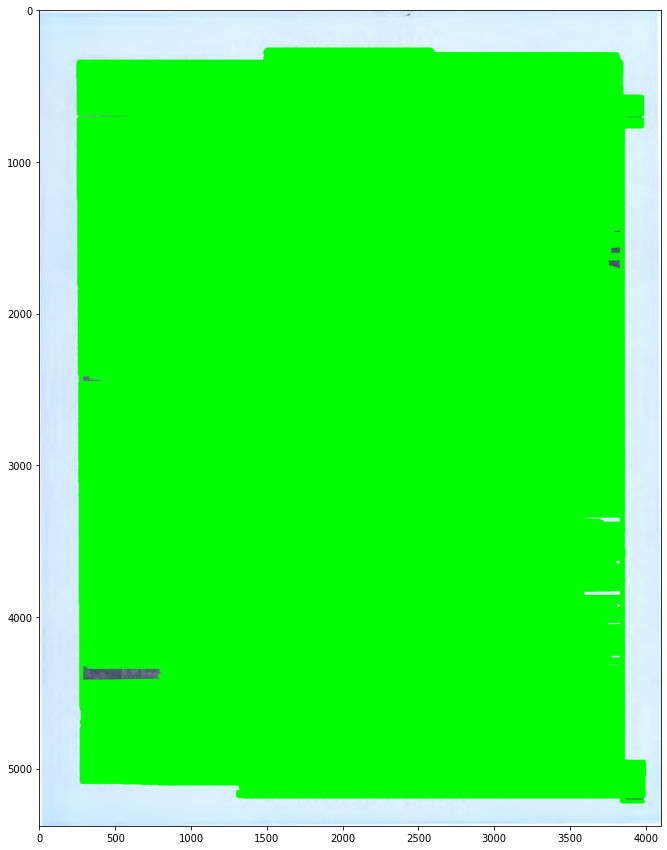

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/home/vimalkumar.s/Documents/pdf_pages/final_images/18/page_18.tif')
#im = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200)
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,maxLineGap = 20000)

for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),25)
    #print(type(img))
    #cv2.imwrite('final_image.jpeg',img)
plt.figure(figsize=(15,15))
plt.imshow(img)
#print(type(img))

In [ ]:
import cv2
import numpy as np
 
im = cv2.imread('new1.png')
plt.figure(figsize = 15,15)
plt.imshow(im)
im = im/255.0
im_power_law_transformation = cv2.pow(im,0.6)
a = Image.fromarray((im_power_law_transformation * 255).astype(np.uint8))
a.save('/home/vimalkumar.s/Documents/table splitting/quality/ss1.jpeg',quality = 99)

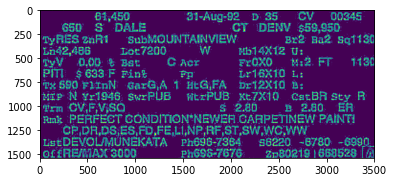

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

img = cv2.imread('new1.png',0)

# global thresholding
ret1,th1 = cv2.threshold(img,210,255,cv2.THRESH_BINARY)
plt.imshow(th1)
a = Image.fromarray(th1)
a.save('/home/vimalkumar/Documents/images/new2.jpeg',quality = 99)